# Generative Adversarial Neural Networks
### ... from scratch

All credit goes to Jeff Heaton, lesson plan and youtube video found [here.](https://github.com/jeffheaton/present/blob/master/youtube/gan/gans_scratch.ipynb)

In [1]:
# Nicely formatted time string
import PIL.Image


def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [3]:
# Following packages are necessary to impolement a basic GAN in Python/Keras

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model

import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [33]:
# The following constants define the creation of the GAN
# Generation resolution - must be square
# training data is also scaled to this
# WARNING: GENERATE_RES 4 or higher
# will blow Google Colab's memory.

GENERATE_RES = 3 # RESOLUTION  = ( 32H X 32W ) * GENERATE_RES
GENERATE_SQUARE = 32 * GENERATE_RES # GENERATE_SQUARE = SIDE LENGTH OF SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

# PREVIEW IMAGE
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# SIZE VECTOR TO GENERATE IMAGES FROM
SEED_SIZE=100

# CONFIG
DATA_PATH = './data'
EPOCHS = 2000
BATCH_SIZE = 64
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE} px by {GENERATE_SQUARE} px images.")





Will generate 96 px by 96 px images.


In [34]:
# Next step is loading and preprocessing the images
import os

training_binary_path = os.path.join(DATA_PATH, f'training_data{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"looking for file: {training_binary_path}")
if not os.path.isfile(training_binary_path):
    start = time.time()
    print("Existing pickle not found...\n...Loading training data!")

    training_data = []

    faces_path = os.path.join(DATA_PATH,'images')
    for filename in tqdm(os.listdir(faces_path)):
        path = os.path.join(faces_path,filename)
        image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE), Image.Resampling.LANCZOS)
        training_data.append(np.asarray(image))
    training_data = np.reshape(training_data,(-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    training_data = training_data.astype(np.float32)
    training_data = training_data/127.5 - 1

    print("Saving training image binary...")
    np.save(training_binary_path,training_data)
    elapsed = time.time() - start
    print(f'preprocess time = {hms_string(elapsed)}')
else:
    print("Unpickling previous binary")
    training_data = np.load(training_binary_path)

looking for file: ./data/training_data96_96.npy
Unpickling previous binary


In [35]:
# Batch and shuffle the training data!
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### The following code actually creates the discriminator and the generator

In [36]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [37]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model



As training progresses, images will be produced to demonstrate the training progress. These images will contain a number of rendered faces to show the progress of the model.  The following function defines those images:

In [38]:
def save_images(cnt,noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS),
      255, dtype=np.uint8)

  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

Generating noise
Generating images of size 96 px square.
Printing image


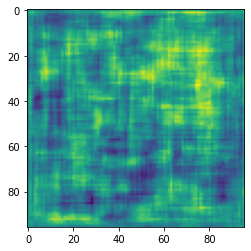

In [39]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
print("Generating noise")
noise = tf.random.normal([1, SEED_SIZE])
print(f"Generating images of size {GENERATE_SQUARE} px square.")
generated_image = generator(noise, training=False)
print("Printing image")
plt.imshow(generated_image[0, :, :, 0])

In [40]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49990103]], shape=(1, 1), dtype=float32)


In [41]:
# returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [42]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [43]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss


In [44]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [45]:
train(train_dataset, 300)

Epoch 1, gen loss=2.7324423789978027,disc loss=0.884803056716919, 0:00:17.18
1/1 [==============================] - 0s 190ms/step
Epoch 2, gen loss=3.321244478225708,disc loss=1.0248271226882935, 0:00:13.24
1/1 [==============================] - 0s 11ms/step
Epoch 3, gen loss=2.969040870666504,disc loss=1.0480729341506958, 0:00:13.31
1/1 [==============================] - 0s 11ms/step
Epoch 4, gen loss=2.9170968532562256,disc loss=0.8534614443778992, 0:00:13.32
1/1 [==============================] - 0s 10ms/step
Epoch 5, gen loss=3.725519895553589,disc loss=0.6784616112709045, 0:00:13.40
1/1 [==============================] - 0s 11ms/step
Epoch 6, gen loss=3.873131513595581,disc loss=0.7041316032409668, 0:00:13.41
1/1 [==============================] - 0s 12ms/step
Epoch 7, gen loss=3.6907224655151367,disc loss=0.732647716999054, 0:00:14.44
1/1 [==============================] - 0s 11ms/step
Epoch 8, gen loss=3.0683155059814453,disc loss=0.8712806105613708, 0:00:16.56
1/1 [============

In [17]:
generator.save(os.path.join(DATA_PATH,"face_generator_128.h5"))

In [91]:
generator.metrics

[]

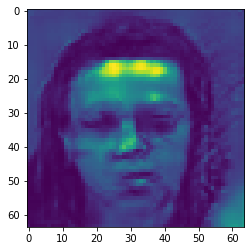

In [21]:
plt.imshow(generator(noise,training=False)[0, :, :, 0])


In [ ]:
generator